### Step 0: Understand data of an Existing Backend

In [1]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *
from qiskit.test.mock import FakeAthens, FakeBoeblingen
from qiskit.transpiler import CouplingMap
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Define a simulated noisy backend
#simulated_backend = FakeBoeblingen()
simulated_backend = FakeAthens()



# Print out basic features of this backend. 
print("---------------------------------Backend Configuration---------------------------------")

config = simulated_backend.configuration()
pp.pprint(config.to_dict())

print("This backend is called {0}, and is on version {1}. \nIt has {2} qubit{3}. \nIt "
      "{4} OpenPulse programs. \nThe basis gates supported on this device are {5}. \nCoupling Map: {6}\n\n"
      "".format(config.backend_name,
                config.backend_version,
                config.n_qubits,
                '' if config.n_qubits == 1 else 's',
                'supports' if config.open_pulse else 'does not support',
                config.basis_gates,
                config.coupling_map))
cm = CouplingMap(config.coupling_map)


print("---------------------------------Backend Properties---------------------------------")
# Print out information about the Properties of the backend.
properties = simulated_backend.properties()
pp.pprint(properties.to_dict())


---------------------------------Backend Configuration---------------------------------
{   'acquisition_latency': [],
    'allow_object_storage': True,
    'allow_q_object': True,
    'backend_name': 'fake_athens',
    'backend_version': '1.3.13',
    'basis_gates': ['id', 'rz', 'sx', 'x', 'cx', 'reset'],
    'channels': {   'acquire0': {   'operates': {'qubits': [0]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire1': {   'operates': {'qubits': [1]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire2': {   'operates': {'qubits': [2]},
                                    'purpose': 'acquire',
                                    'type': 'acquire'},
                    'acquire3': {   'operates': {'qubits': [3]},
                                    'purpose': 'acquire',
                                

## Make our own Backend
### Step 1: Defining Backend Configuration (i.e. Coupling Map, Basis Gates, etc.)
For more information about **Backend Configuration** Object please click here. **[HERE](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendConfiguration.html#qiskit.providers.models.BackendConfiguration)**

More information about GateConfig is found **[HERE](https://qiskit.org/documentation/stubs/qiskit.providers.models.GateConfig.html)**

In [2]:
# Used for Backend Configuration
from qiskit.providers import BaseBackend
from qiskit.providers import BackendV1
from qiskit.providers.models import BackendConfiguration
from qiskit.providers.models.backendconfiguration import GateConfig
from qiskit.transpiler import CouplingMap


######################################### Backend Configuration #########################################
backend_name = "HAD"
backend_version = "1.0"
n_qubits = 5
basis_gates = ['id', 'u1', 'u2', 'u3', 'cx']


#Gate Configs
gate_config1 = GateConfig(name="id", 
                          parameters=[], 
                          qasm_def='gate id q { U(0, 0, 0) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config2 = GateConfig(name="u1", 
                          parameters=['lambda'], 
                          qasm_def='gate u1(lambda) q { U(0, 0, lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config3 = GateConfig(name="u2", 
                          parameters=['phi', 'lambda'], 
                          qasm_def='gate u2(phi, lambda) q { U(pi/2, phi, '
                                   'lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config4 = GateConfig(name="u3", 
                          parameters=['theta', 'phi', 'lambda'], 
                          qasm_def='gate u3(theta, phi, lambda) q { U(theta, '
                                   'phi, lambda) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config5 = GateConfig(name="cx", 
                          parameters=[], 
                          qasm_def='gate cx q0, q1 { CX q0, q1; }',
                          coupling_map=[[0, 1],
                                        [1, 0],
                                        [0, 2],
                                        [2, 0],
                                        [1, 3],
                                        [3, 1],
                                        [2, 3],
                                        [3, 2],
                                        [2, 4],
                                        [4, 2],
                                        [3, 4],
                                        [4, 3]])

gates = [gate_config1, gate_config2, gate_config3, gate_config4, gate_config5]

coupling_map = [[0, 1],
                [1, 0],
                [0, 2],
                [2, 0],
                [1, 3],
                [3, 1],
                [2, 3],
                [3, 2],
                [2, 4],
                [4, 2],
                [3, 4],
                [4, 3]]

# Create BackendConfiguration Object
HAD_config = BackendConfiguration(backend_name=backend_name, 
                                     backend_version=backend_version,
                                     n_qubits=n_qubits,
                                     basis_gates=basis_gates,
                                     gates=gates,
                                     local=True,
                                     simulator=True,
                                     conditional=True,
                                     open_pulse=True,
                                     memory=True,
                                     max_shots=1024,
                                     coupling_map=coupling_map
                                     );

### Step 2: Defining Backend Properties (i.e. Gate Errors on each qubit, Gate Length, Qubit T1 & T2 times, etc)
For more information about **Backend Properties** Object please click here. **[HERE](https://qiskit.org/documentation/stubs/qiskit.providers.models.BackendProperties.html#qiskit.providers.models.BackendProperties)**

In [3]:
# Used for Backend Properties
from qiskit.providers.models import BackendProperties
from datetime import datetime
import datetime as dt
from dateutil.tz import tzoffset
from qiskit.providers.models.backendproperties import *
######################################### Backend Properties #########################################
#backend_name = "HAD"
#backend_version = "1.0"
#last_update_date = datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400))


# PROPERTIES WERE PLACED DIRECTLY IN HAD_Backend CLASS. lOOK AT STEP 3.
#HAD_properties =

# Create BackendProperties Object
#BackendProperties(backend_name=backend_name, backend_version=backend_version, last_update_date=last_update_date, qubits=qubits, gates=gates, general=general)

### Step 3: Creating a Backend Object using Backend Configuration and Backend Properties
We will be using **BackendV1** here. However, for more information about the three different types of Backend Objects, please click the following:
1) **[BackendV2](https://qiskit.org/documentation/stubs/qiskit.providers.BackendV2.html)**

2) **[BackendV1](https://qiskit.org/documentation/stubs/qiskit.providers.BackendV1.html)**

3) **[BaseBackend_Deprecated](https://qiskit.org/documentation/stubs/qiskit.providers.BaseBackend.html)**

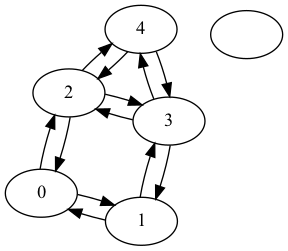

In [4]:
# Used for run method.
from qiskit.quantum_info import Statevector
from qiskit.result import Counts

# Used for Backend Properties
from qiskit.providers.models import BackendProperties
from datetime import datetime
import datetime as dt
#from dateutil import tz
from dateutil.tz import tzoffset
from qiskit.providers.models.backendproperties import *



class HAD_Backend(BackendV1):
    #def __init__(self, configuration, provider, **fields):
    #    super().__init__(configuration, provider, **fields)
    #    #self.properties = properties    
    
    def _default_options(cls):
        pass
    
    # Verbose (print qasm-like execution log) on by default
    # Shots set to 1000 by default
    def run(self, run_input, **options): 

        # Find subsystems we want to measure at end (without doing it yet)
        measure_qubits = []
        for i in run_input.get_instructions("measure"):
            measure_qubit = i[1][0]
            measure_qreg = measure_qubit.index
            measure_qubits.append(measure_qreg)
            
        # Translate to openqasm string and print line by line
        if 'verbose' not in options or options['verbose'] == True:
            qasm = run_input.qasm()
            self.parse(qasm)

        # Simulate statevector
        no_measure = run_input.copy()
        no_measure.remove_final_measurements()
        sv = Statevector(no_measure)

        # Determine shots and do measurements
        if 'shots' not in options:
            shots = 1000
        else:
            shots = options['shots']
        counts = sv.sample_counts(shots, measure_qubits)
        return Counts(counts)
        

    def parse(self, qasm):
        for line in qasm.splitlines():
            if 'OPENQASM' in line or 'include' in line:
                continue
            elif 'qreg' in line:
                num_qubits = line.split('[')[-1].split(']')[0] 
                print("Allocating", num_qubits, "qubits for use")
            elif 'creg' in line:
                num_bits = line.split('[')[-1].split(']')[0]
                print("Allocating", num_bits, "classical bits for use")
            elif 'measure' in line:
                qubit = line.split('[')[-2].split(']')[0]
                bit = line.split('[')[-1].split(']')[0]
                print("Measuring qubit", qubit, "into classical bit", bit)
            else:
                qubits = []
                toks = line.split('[')
                gate = toks[0][:-2]
                for tok in toks:
                    if ']' not in tok:
                        continue
                    qubits.append(tok.split(']')[0])
                print("Performing " + gate + " on the following qubit(s):", qubits)
    

    def properties(self):
        """Return backend properties"""

        properties = {   'backend_name': 'HAD',
    'backend_version': '1.0',
    # Gate Errors and Gate Lengths
    ########## id Gate Error and Gate Length
     'gates': [   {  'gate': 'id',
                     'name': 'id0',
                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_error',
                                           'unit': '',
                                           'value': 0.00023855765187208629},
                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_length',
                                           'unit': 'ns',
                                           'value': 35.55555555555556}],
                     'qubits': [0]},
                 {   'gate': 'id',
                     'name': 'id1',
                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_error',
                                           'unit': '',
                                           'value': 0.00031184241260348973},
                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_length',
                                           'unit': 'ns',
                                           'value': 35.55555555555556}],
                     'qubits': [1]},
                 {   'gate': 'id',
                     'name': 'id2',
                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_error',
                                           'unit': '',
                                           'value': 0.0005399110585891418},
                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_length',
                                           'unit': 'ns',
                                           'value': 35.55555555555556}],
                     'qubits': [2]},
                 {   'gate': 'id',
                     'name': 'id3',
                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_error',
                                           'unit': '',
                                           'value': 0.00032460860123477756},
                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_length',
                                           'unit': 'ns',
                                           'value': 35.55555555555556}],
                     'qubits': [3]},
                 {   'gate': 'id',
                     'name': 'id4',
                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_error',
                                           'unit': '',
                                           'value': 0.00046067926001784333},
                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                           'name': 'gate_length',
                                           'unit': 'ns',
                                           'value': 35.55555555555556}],
                     'qubits': [4]},

        ########## U1 Gate Error and Gate Length
                  {   'gate': 'u1',
                             'name': 'u10',
                             'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_error',
                                                   'unit': '',
                                                   'value': 0},
                                               {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_length',
                                                   'unit': 'ns',
                                                   'value': 0}],
                             'qubits': [0]},
                         {   'gate': 'u1',
                             'name': 'u11',
                             'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_error',
                                                   'unit': '',
                                                   'value': 0},
                                               {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_length',
                                                   'unit': 'ns',
                                                   'value': 0}],
                             'qubits': [1]},
                         {   'gate': 'u1',
                             'name': 'u12',
                             'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_error',
                                                   'unit': '',
                                                   'value': 0},
                                               {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_length',
                                                   'unit': 'ns',
                                                   'value': 0}],
                             'qubits': [2]},
                         {   'gate': 'u1',
                             'name': 'u13',
                             'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_error',
                                                   'unit': '',
                                                   'value': 0},
                                               {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_length',
                                                   'unit': 'ns',
                                                   'value': 0}],
                             'qubits': [3]},
                         {   'gate': 'u1',
                             'name': 'u14',
                             'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_error',
                                                   'unit': '',
                                                   'value': 0},
                                               {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                   'name': 'gate_length',
                                                   'unit': 'ns',
                                                   'value': 0}],
                             'qubits': [4]},

        ########## U2 Gate Error and Gate Length
                          {   'gate': 'u2',
                                     'name': 'u20',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.00023855765187208629},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 35.55555555555556}],
                                     'qubits': [0]},
                                 {   'gate': 'u2',
                                     'name': 'u21',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.00031184241260348973},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 35.55555555555556}],
                                     'qubits': [1]},
                                 {   'gate': 'u2',
                                     'name': 'u22',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.0005399110585891418},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 35.55555555555556}],
                                     'qubits': [2]},
                                 {   'gate': 'u2',
                                     'name': 'u23',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.00032460860123477756},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 35.55555555555556}],
                                     'qubits': [3]},
                                 {   'gate': 'u2',
                                     'name': 'u24',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.00046067926001784333},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 35.55555555555556}],
                                     'qubits': [4]},

        ########## U3 Gate Error and Gate Length
                          {   'gate': 'u3',
                                     'name': 'u30',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.00047705839399092564},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 71.11111111111111}],
                                     'qubits': [0]},
                                 {   'gate': 'u3',
                                     'name': 'u31',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.0006235875795167489},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 71.11111111111111}],
                                     'qubits': [1]},
                                 {   'gate': 'u3',
                                     'name': 'u32',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.0010795306132271865},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 71.11111111111111}],
                                     'qubits': [2]},
                                 {   'gate': 'u3',
                                     'name': 'u33',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 21, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.0006491118317254463},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 71.11111111111111}],
                                     'qubits': [3]},
                                 {   'gate': 'u3',
                                     'name': 'u34',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.0009211462946550064},
                                                       {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 71.11111111111111}],
                                     'qubits': [4]},


        ########## CX Gate Error and Gate Length
                          {   'gate': 'cx',
                                     'name': 'cx0_1',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.020032216579437295},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 533.3333333333333}],
                                     'qubits': [0, 1]},
                                 {   'gate': 'cx',
                                     'name': 'cx1_0',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.020032216579437295},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 568.8888888888889}],
                                     'qubits': [1, 0]},
                                 {   'gate': 'cx',
                                     'name': 'cx0_2',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 32, 16, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.018250372005311738},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 746.6666666666666}],
                                     'qubits': [0, 2]},
                                 {   'gate': 'cx',
                                     'name': 'cx2_0',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 21, 32, 16, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.018250372005311738},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 782.2222222222222}],
                                     'qubits': [2, 0]},
                                 {   'gate': 'cx',
                                     'name': 'cx1_3',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 59, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.01741073961564263},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 405.3333333333333}],
                                     'qubits': [1, 3]},
                                 {   'gate': 'cx',
                                     'name': 'cx3_1',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 59, 56, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.01741073961564263},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 440.88888888888886}],
                                     'qubits': [3, 1]},



                                {   'gate': 'cx',
                                     'name': 'cx2_3',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 46, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.022010851878566384},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 448}],
                                     'qubits': [2, 3]},
                                 {   'gate': 'cx',
                                     'name': 'cx3_2',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 46, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.022010851878566384},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 483.55555555555554}],
                                     'qubits': [3, 2]},
                                 {   'gate': 'cx',
                                     'name': 'cx2_4',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 35, 39, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.01770335844976184},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 512}],
                                     'qubits': [2, 4]},
                                 {   'gate': 'cx',
                                     'name': 'cx4_2',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 35, 39, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.01770335844976184},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 547.5555555555555}],
                                     'qubits': [4, 2]},
                                 {   'gate': 'cx',
                                     'name': 'cx3_4',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 19, 58, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.014428107180732508},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 384}],
                                     'qubits': [3, 4]},
                                 {   'gate': 'cx',
                                     'name': 'cx4_3',
                                     'parameters': [   {   'date': datetime.datetime(2021, 2, 3, 20, 19, 58, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_error',
                                                           'unit': '',
                                                           'value': 0.014428107180732508},
                                                       {   'date': datetime.datetime(2021, 1, 31, 21, 40, 50, tzinfo=tzoffset(None, -18000)),
                                                           'name': 'gate_length',
                                                           'unit': 'ns',
                                                           'value': 419.55555555555554}],
                                     'qubits': [4, 3]}],
 
            'general': [   {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'jq_12',
                                   'unit': 'GHz',
                                   'value': 0.001715963318618043},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'zz_12',
                                   'unit': 'GHz',
                                   'value': -6.739337717569015e-05},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'jq_34',
                                   'unit': 'GHz',
                                   'value': 0.0014300376658986506},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'zz_34',
                                   'unit': 'GHz',
                                   'value': -7.676209360402695e-05},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'jq_01',
                                   'unit': 'GHz',
                                   'value': 0.00167045114712927},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'zz_01',
                                   'unit': 'GHz',
                                   'value': -3.802523473566748e-05},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'jq_23',
                                   'unit': 'GHz',
                                   'value': 0.001419786134211377},
                               {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                   'name': 'zz_23',
                                   'unit': 'GHz',
                                   'value': -4.029010458592919e-05}],

             'last_update_date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
    
            'qubits': [   [   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T1',
                                      'unit': 'us',
                                      'value': 63.487830217083875},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 16, 8, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T2',
                                      'unit': 'us',
                                      'value': 112.23245535599808},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'frequency',
                                      'unit': 'GHz',
                                      'value': 5.1753836395136075},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'anharmonicity',
                                      'unit': 'GHz',
                                      'value': -0.33610237055834047},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_error',
                                      'unit': '',
                                      'value': 0.010099999999999998},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas0_prep1',
                                      'unit': '',
                                      'value': 0.018000000000000016},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas1_prep0',
                                      'unit': '',
                                      'value': 0.0022},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_length',
                                      'unit': 'ns',
                                      'value': 3022.222222222222}],
                              [   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T1',
                                      'unit': 'us',
                                      'value': 73.093518301544},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 17, 38, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T2',
                                      'unit': 'us',
                                      'value': 126.83382141649017},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'frequency',
                                      'unit': 'GHz',
                                      'value': 5.267216864382969},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'anharmonicity',
                                      'unit': 'GHz',
                                      'value': -0.33254504412181485},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_error',
                                      'unit': '',
                                      'value': 0.011700000000000044},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas0_prep1',
                                      'unit': '',
                                      'value': 0.018000000000000016},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas1_prep0',
                                      'unit': '',
                                      'value': 0.0054},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_length',
                                      'unit': 'ns',
                                      'value': 3022.222222222222}],
                              [   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T1',
                                      'unit': 'us',
                                      'value': 32.91818023387998},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 16, 8, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T2',
                                      'unit': 'us',
                                      'value': 59.80643883454234},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'frequency',
                                      'unit': 'GHz',
                                      'value': 5.0524024697946635},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'anharmonicity',
                                      'unit': 'GHz',
                                      'value': -0.3370771771901723},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_error',
                                      'unit': '',
                                      'value': 0.02429999999999999},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas0_prep1',
                                      'unit': '',
                                      'value': 0.034599999999999964},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas1_prep0',
                                      'unit': '',
                                      'value': 0.014},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_length',
                                      'unit': 'ns',
                                      'value': 3022.222222222222}],
                              [   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T1',
                                      'unit': 'us',
                                      'value': 49.51084562967435},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 17, 38, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T2',
                                      'unit': 'us',
                                      'value': 20.55130827115546},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'frequency',
                                      'unit': 'GHz',
                                      'value': 4.855916030466884},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'anharmonicity',
                                      'unit': 'GHz',
                                      'value': -0.32483596191153774},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_error',
                                      'unit': '',
                                      'value': 0.01529999999999998},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas0_prep1',
                                      'unit': '',
                                      'value': 0.0242},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas1_prep0',
                                      'unit': '',
                                      'value': 0.0064},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_length',
                                      'unit': 'ns',
                                      'value': 3022.222222222222}],
                              [   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T1',
                                      'unit': 'us',
                                      'value': 111.44095341923331},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 16, 8, tzinfo=tzoffset(None, -14400)),
                                      'name': 'T2',
                                      'unit': 'us',
                                      'value': 168.76253828389227},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'frequency',
                                      'unit': 'GHz',
                                      'value': 5.118554567140891},
                                  {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                                      'name': 'anharmonicity',
                                      'unit': 'GHz',
                                      'value': -0.3361334185218728},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_error',
                                      'unit': '',
                                      'value': 0.02190000000000003},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas0_prep1',
                                      'unit': '',
                                      'value': 0.03259999999999996},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'prob_meas1_prep0',
                                      'unit': '',
                                      'value': 0.0112},
                                  {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                                      'name': 'readout_length',
                                      'unit': 'ns',
                                      'value': 3022.222222222222}]]
        }

        return BackendProperties.from_dict(properties)
    
    
# HAD properties were placed directly in class. Should modify later for better readability. 
HAD_custom_backend = HAD_Backend(configuration=HAD_config)
#pp.pprint(HAD_custom_backend.configuration().to_dict())
#pp.pprint(HAD_custom_backend.properties().to_dict())

# Get qiskit properties
#from qiskit import IBMQ, transpile
#from qiskit import QuantumCircuit
#from qiskit.providers.aer import AerSimulator
#from qiskit.tools.visualization import plot_histogram
#from qiskit import IBMQ, Aer
#from qiskit.providers.aer.noise import NoiseModel


# IGNORE THIS. DEBBUGING.
#HAD_custom_backend = HAD_Backend(configuration=backendConfig, provider="Hello", properties=properties)

# IGNRORE THIS.DEBUGGING.
#sim_athens = AerSimulator.from_backend(simulated_backend)
#pp.pprint(sim_athens)

# IGNORE THIS. DEBUGGING.
#noise_model = NoiseModel.from_backend(HAD_custom_backend)
#pp.pprint(noise_model.to_dict())
#pp.pprint(HAD_custom_backend.properties().to_dict())


# Print Coupling Map
cm = CouplingMap(HAD_config.coupling_map)
cm.draw()

### Step 4: B-V Circuit

Untranspiled
Depth: 6
Gate counts: OrderedDict([('h', 7), ('measure', 3), ('barrier', 2), ('cx', 2), ('z', 1), ('id', 1)])


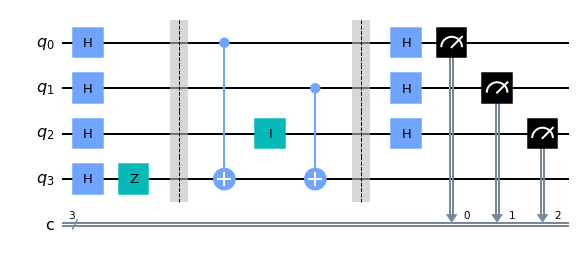

In [5]:
# For Passes
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller



### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
untranspiled_qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
untranspiled_qc.h(n)
untranspiled_qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    untranspiled_qc.h(i)
    
# Apply barrier
untranspiled_qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        untranspiled_qc.i(q)
    else:
        untranspiled_qc.cx(q, n)
        
# Apply barrier
untranspiled_qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    untranspiled_qc.h(i)


# Measurement
for i in range(n):
    untranspiled_qc.measure(i, i)


untranspiled_qc = transpile(untranspiled_qc, backend=None)  # No Optimization and no mapping because we have not specified a backend.
print('Untranspiled')
print('Depth:', untranspiled_qc.depth())
print('Gate counts:', untranspiled_qc.count_ops())
untranspiled_qc.draw("mpl")

### HAD Backend NO Noise

Transpiled
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


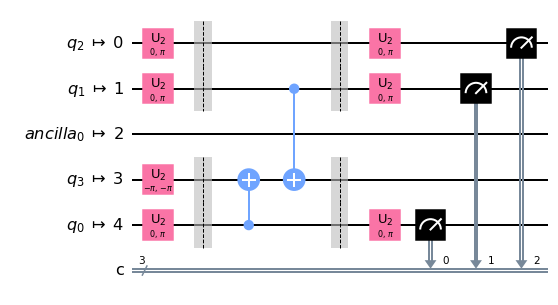

In [6]:
transpiled_qc = transpile(untranspiled_qc, HAD_custom_backend, optimization_level=3)
print('Transpiled')
print('Depth:', transpiled_qc.depth())
print('Gate counts:', transpiled_qc.count_ops())
transpiled_qc.draw("mpl")

/var/folders/sz/0cdcg0js763gfjpq1kj566p00000gn/T/ipykernel_37451/3155961351.py:31: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  measure_qreg = measure_qubit.index


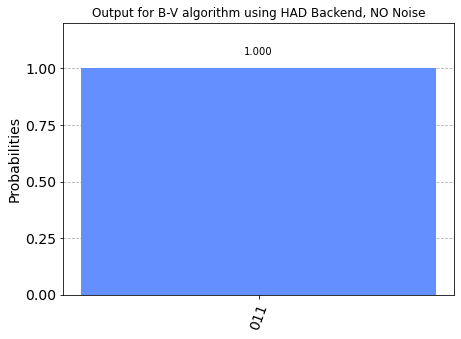

In [7]:
from qiskit.visualization import plot_histogram
# 3) Now, we can execute the transpiled circuit on the simulated noisy backend
results = HAD_custom_backend.run(transpiled_qc, verbose=False, shots=50)
plot_histogram(results, title='Output for B-V algorithm using HAD Backend, NO Noise')

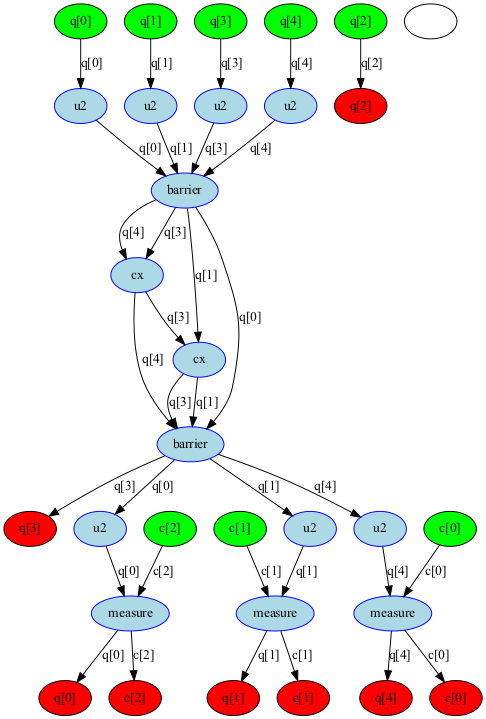

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer

# Required software to visually see DAG
# !pip install pydot

# Draw DAG of the transpiled circuit that used optimization_level=0
dag = circuit_to_dag(transpiled_qc)
dag_drawer(dag)

### HAD Backend With Noise
The `AerSimulator.from_backend` uses the HAD properties to automatically create a `Noise model`.   

Transpiled
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


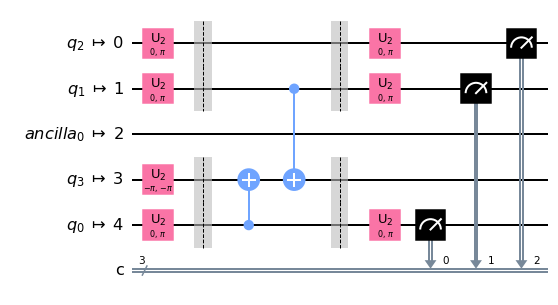

In [9]:
from qiskit.providers.aer import AerSimulator


HAD_custom_backend_with_noise = AerSimulator.from_backend(HAD_custom_backend)
transpiled_qc_noisy = transpile(untranspiled_qc, HAD_custom_backend_with_noise, optimization_level=3)
print('Transpiled')
print('Depth:', transpiled_qc.depth())
print('Gate counts:', transpiled_qc.count_ops())
transpiled_qc.draw("mpl")

In [ ]:
from qiskit.visualization import plot_histogram
# 3) Now, we can execute the transpiled circuit on the simulated noisy backend
noisy_result = HAD_custom_backend_with_noise.run(transpiled_qc_noisy).result()
noisy_counts = noisy_result.get_counts(transpiled_qc_noisy)
plot_histogram(noisy_counts,
               title='Output for B-V algorithm using HAD Noisy Backend')

### Miscellaneous. Everything after this is just for testing and trying stuff out.

In [ ]:
#Basis Gates used by FakeAthens Backend
''' 
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']

gate_config1 = GateConfig(name="id", 
                          parameters=[], 
                          qasm_def='gate id q { U(0, 0, 0) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config2 = GateConfig(name="rz", 
                          parameters=['theta'], 
                          qasm_def='gate rz(theta) q { U(0, 0, theta) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config3 = GateConfig(name="sx", 
                          parameters=[], 
                          qasm_def='gate sx q { U(pi/2, 3*pi/2, pi/2) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config4 = GateConfig(name="x", 
                          parameters=[], 
                          qasm_def='gate x q { U(pi, 0, pi) q; }',
                          coupling_map=[[0], [1], [2], [3], [4]])

gate_config5 = GateConfig(name="cx", 
                          parameters=[], 
                          qasm_def='gate cx q0, q1 { CX q0, q1; }',
                          coupling_map=[[0, 1],
                                        [1, 0],
                                        [0, 2],
                                        [2, 0],
                                        [1, 3],
                                        [3, 1],
                                        [2, 3],
                                        [3, 2],
                                        [2, 4],
                                        [4, 2],
                                        [3, 4],
                                        [4, 3]])
'''

In [ ]:
# Used for Backend Properties
from qiskit.providers.models import BackendProperties
from datetime import datetime
import datetime as dt
from dateutil import tz
from qiskit.providers.models.backendproperties import *
from qiskit.circuit import Gate
from qiskit.circuit import ParameterExpression, Parameter
######################################### Backend Properties #########################################
'''
backend_name = "HAD"
backend_version = "1.0"
last_update_date = datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tz.tzoffset(None, -14400))
qubits = [[         Nduv(date= datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'T1',
                          unit= 'us',
                          value= 63.487830217083875),
                    Nduv(date=datetime.datetime(2021, 3, 15, 0, 16, 8, tzinfo=tz.tzoffset(None, -14400)),
                          name='T2',
                          unit= 'us',
                          value= 112.23245535599808),
                    Nduv(date= datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'frequency',
                          unit= 'GHz',
                          value= 5.1753836395136075),
                    Nduv(date= datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'anharmonicity',
                          unit= 'GHz',
                          value= -0.33610237055834047),
                    Nduv(date= datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'readout_error',
                          unit= '',
                          value= 0.010099999999999998),
                    Nduv(date= datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'prob_meas0_prep1',
                          unit= '',
                          value= 0.018000000000000016),
                    Nduv(date= datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'prob_meas1_prep0',
                          unit= '',
                          value= 0.0022),
                    Nduv(date= datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tz.tzoffset(None, -14400)),
                          name= 'readout_length',
                          unit= 'ns',
                          value= 3022.222222222222)]]
                          

'qubits': [[   {   'date': datetime.datetime(2021, 3, 15, 0, 15, 3, tzinfo=tzoffset(None, -14400)),
                  'name': 'T1',
                  'unit': 'us',
                  'value': 63.487830217083875},
              {   'date': datetime.datetime(2021, 3, 15, 0, 16, 8, tzinfo=tzoffset(None, -14400)),
                  'name': 'T2',
                  'unit': 'us',
                  'value': 112.23245535599808},
              {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                  'name': 'frequency',
                  'unit': 'GHz',
                  'value': 5.1753836395136075},
              {   'date': datetime.datetime(2021, 3, 15, 14, 10, 39, tzinfo=tzoffset(None, -14400)),
                  'name': 'anharmonicity',
                  'unit': 'GHz',
                  'value': -0.33610237055834047},
              {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                  'name': 'readout_error',
                  'unit': '',
                  'value': 0.010099999999999998},
              {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                  'name': 'prob_meas0_prep1',
                  'unit': '',
                  'value': 0.018000000000000016},
              {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                  'name': 'prob_meas1_prep0',
                  'unit': '',
                  'value': 0.0022},
              {   'date': datetime.datetime(2021, 3, 15, 0, 14, 2, tzinfo=tzoffset(None, -14400)),
                  'name': 'readout_length',
                  'unit': 'ns',
                  'value': 3022.222222222222}]]


#name (str) – The Qobj name of the gate.
#num_qubits (int) – The number of qubits the gate acts on.
#params (List) – A list of parameters.
#label (Optional[str]) – An optional label for the gate.

gates = [   Gate(name= 'id0',
                 num_qubits=1,
                 params= [ParameterExpression({   Parameter('date'): datetime.datetime(2021, 2, 3, 5, 14, 11, tzinfo=tz.tzoffset(None, -18000)),
                                           Parameter('name'): 'gate_error',
                                           Parameter('unit'): '',
                                           Parameter('value'): 0.00023855765187208629}),
                         ParameterExpression({   Parameter('date'): datetime.datetime(2021, 2, 3, 21, 40, 50, tzinfo=tz.tzoffset(None, -18000)),
                                           Parameter('name'): 'gate_length',
                                           Parameter('unit'): 'ns',
                                           Parameter('value'): 35.55555555555556})])]
'''



In [ ]:
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ, transpile
from qiskit import QuantumCircuit
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

# Construct quantum circuit
circ = QuantumCircuit(3, 3)
circ.h(0)
circ.cx(0, 1)
circ.cx(1, 2)
circ.measure([0, 1, 2], [0, 1, 2])

'''
sim_ideal = AerSimulator()
# Execute and get counts
result = sim_ideal.run(transpile(circ, sim_ideal)).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Ideal counts for 3-qubit GHZ state')
'''
# Can do this. You may define Noise model first, and then use that in AerSimulator. However, AerSimulator create the
# noise model automatically from the simulated backend. You can see this in the source code.
#noise_model = NoiseModel.from_backend(simulated_backend)
#exampleSim = AerSimulator.from_backend(simulated_backend, noise_model=noise_model)

# Simpler. Just provide the backend (must have backend properties and backend configuration defined). 
# Then the AerSimulator.from_backend will create the noise model for you automatically.
exampleSim = AerSimulator.from_backend(simulated_backend)
transpiledCirc = transpile(circ, exampleSim, optimization_level=0)
result = exampleSim.run(transpiledCirc).result()
counts = result.get_counts(0)
plot_histogram(counts, title='Noisy counts for 3-qubit GHZ state')